# Spline approximation by least squares

Continuation of Ex 10. Find $n+1$ controlpoints $p_j∈R^2$ such that $\sum_{i=0}^{m−1}‖γ(t_i)−S(t_i)‖^2_2 = min$ where 
$S:[0,1]→R^2$ is the spline curve. Try with various numbers $m$ of uniformly distributed points $t_i$, from 1 to 10 points per spline interval. Solve the least squares problem by either the normal equation method, by the QR decomposition or by SVD.

$$ γ: [0,1]→R^2:t→((t+ 1) cos(4πt),(t+ 1) sin(4πt)) $$

$$ t → \sum_{j=0}^n p_j N_{j,k}(t) $$

for $k= 1,2,3,4$.  Choose uniformly distributed knots, with $k$ multiple knots at the ends.

Observations:

-  The problem is linear in the coordinates of the control points. Therefore we can estimate the control points in a least squares adjustment without lineariziation.
-  The x and y coordinates are independent and therefore can be estimated independently.

Calculation via 
$$ x = (A^TA)^{-1} \cdot A^T l $$
with 
-  $x$ containing the coordinates of the control points
-  $l$ the coordinates of the "measured" points $γ(t_i)$
-  $A$ containing the values of the different spline basis function for the $t_i$ corresponding to $γ(t_i)$

Structure of equation system:

$$ A(t_i) p = \gamma(t_i) + v_i $$

$$ \left(\begin{array}{cccc} 
N_{0, k}(t_0) & N_{1, k}(t_0) & \dots & N_{n, k}(t_0)\\
N_{0, k}(t_1) & N_{1, k}(t_1) & \dots & N_{n, k}(t_1)\\
\vdots & \vdots & \vdots & \vdots\\
N_{0, k}(t_{m-1}) & N_{1, k}(t_{m-1}) & \dots & N_{n, k}(t_{m-1})\\
\end{array}\right) \cdot \left(\begin{array}{cc} 
p_{0, x} & p_{0, y}\\
p_{1, x} & p_{1, y}\\
\vdots & \vdots\\
p_{n, x} & p_{n, y}\\
\end{array}\right) = \left(\begin{array}{cc} 
\gamma(t_0)_x & \gamma(t_0)_y\\
\gamma(t_0)_x & \gamma(t_0)_y\\
\vdots & \vdots\\
\gamma(t_{m-1})_x & \gamma(t_{m-1})_y\\
\end{array}\right)$$



In [353]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import warnings
import matplotlib as mpl

warnings.filterwarnings('ignore')

def gamma(t):
    return np.array(((t+1)*np.cos(4*np.pi*t),(t+1)*np.sin(4*np.pi*t))).T

In [409]:
def bspline_base_functions(t_list, x_list, plot_basefun=False, multiple_outer_knots=False, k_max=None):   
    x_list = x_list.T
    
    if k_max is None:
        k_max = t_list.size-1-1
       
    if multiple_outer_knots:
        t_list = np.concatenate((np.ones((1, k_max-1))*t_list[0, 0], 
                                 t_list, np.ones((1, k_max-1))*t_list[-1, -1]), axis=1)
    
    n = t_list.size-1

    # create base functions of first order:
    N = np.logical_and((x_list >= t_list[:, :-1]), (x_list < t_list[:, 1:])) * 1.0
    
    if plot_basefun:
        plt.figure()
        plt.plot(N)
        plt.title("Order 0")
    
    # create higher order base functions
    for order in range(2, k_max+1):
        # generate vector with t_j+k-t_j for the two denomenators
        du = t_list[:, order-1:] - t_list[:, :-order+1]
        
        j_max = n-order+1
        
        (x_list - t_list[:, :j_max]) / du[:, :-1]
        
        N_part1 = (x_list - t_list[:, :j_max]) / du[:, :-1] * N[:, :-1]
        N_part1 = np.nan_to_num(N_part1)
        N_part1[N_part1 == -np.inf] = 0
        N_part1[N_part1 == np.inf] = 0
    
        
        N_part2 = (t_list[:, n-j_max+1:] - x_list) / du[:, 1:] * N[:, 1:]
        N_part2 = np.nan_to_num(N_part2)
        N_part2[N_part2 == -np.inf] = 0
        N_part2[N_part2 == np.inf] = 0

        N = N_part1 + N_part2;
        
        if plot_basefun:
            plt.figure()
            plt.plot(N)
            plt.title("Order "+str(order))
            
    N[-1, -1] = 1
    return N

<Figure size 432x288 with 0 Axes>

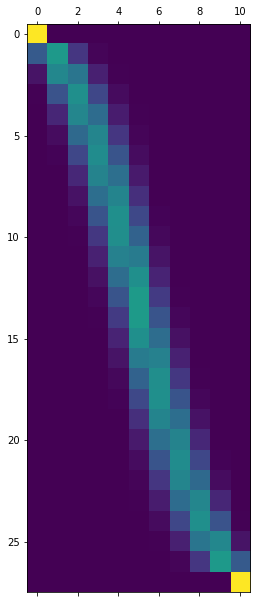

In [475]:
m =4
n = 7  # number control points
k_max = 6
number_observed_pts = n*m
t_list = np.linspace(0, 1, n, endpoint=True)[np.newaxis]
x_list = np.linspace(0, 1, number_observed_pts, endpoint=True)

A = bspline_base_functions(t_list, x_list[np.newaxis], plot_basefun=False, multiple_outer_knots=True, k_max=k_max)

plt.figure()
plt.matshow(A)

x = np.linalg.inv(A.T @ A) @ A.T @ gamma(x_list)

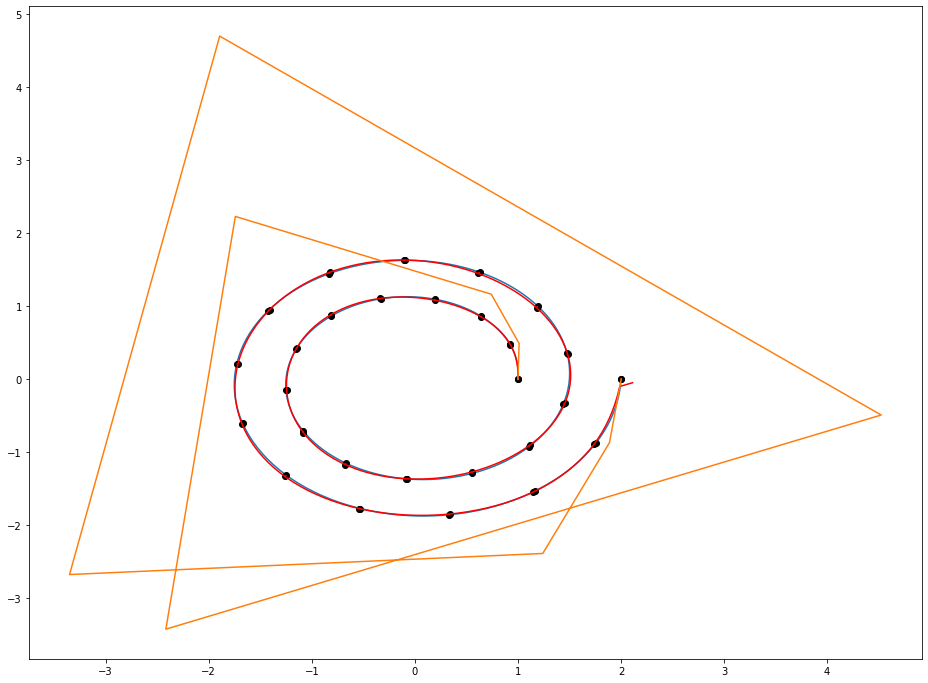

In [476]:
x_plot = np.linspace(0, 1, 500, endpoint=False)

N = bspline_base_functions(t_list, x_plot[np.newaxis], plot_basefun=False, multiple_outer_knots=True, k_max=k_max)
spline_inter = N @ x
ref = gamma(x_plot)

measured_pts = gamma(x_list)
corresponding_pts = A @ x

plt.figure(figsize=(16, 12))
plt.plot(ref[:, 0], ref[:, 1])
plt.plot(measured_pts[:, 0], measured_pts[:, 1], 'ok')
plt.plot(corresponding_pts[:, 0], corresponding_pts[:, 1], 'ok')
plt.plot([corresponding_pts[:, 0], measured_pts[:, 0]], [corresponding_pts[:, 1], measured_pts[:, 1]], '--r')
plt.plot(spline_inter[:, 0], spline_inter[:, 1], 'r')
plt.plot(x[:, 0], x[:, 1])
